In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot,EnhancerDatasetWithID
import pandas as pd
from tqdm import tqdm
import glob
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3,DeepSTARR


In [2]:
def evaluate_model_with_weights(model, data_loader, weight_file, device):
    model.load_state_dict(torch.load(weight_file, map_location=device))
    model.eval()
    
    all_predictions, all_labels, all_fragment_ids = [], [], []
    with torch.no_grad():
        for inputs, labels, fragment_ids in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_fragment_ids.append(fragment_ids)
    
    return (np.concatenate(all_predictions),
            np.concatenate(all_labels),
            np.concatenate(all_fragment_ids))

def process_and_save_results(data_loader, loader_name, model, weight_file, target_labels, output_dir, device, save = True):
    predictions, labels, fragment_ids = evaluate_model_with_weights(model, data_loader, weight_file, device)
    
    # Construct DataFrame
    data = {'Fragment_ID': fragment_ids}
    for i, label in enumerate(target_labels):
        data[f'Predictions_{label}'] = predictions[:, i]
        data[f'True_{label}'] = labels[:, i]

    # Create and save DataFrame
    df_predictions = pd.DataFrame(data)
    if save:
        output_file = f'{output_dir}/{loader_name}_prediction_results.csv'
        df_predictions.to_csv(output_file, index=False)
        print(f"Results for {loader_name} saved to {output_file}")
    return df_predictions


# Train ExplaiNN Predict Merged GFP

In [ ]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_GFP_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 20]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 20
target_labels = ["GFP"]
feature_list = ["GFP"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Merged_Pred_20NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 20
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 566
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 0.1444
Epoch 1/200 -- Train Loss: 0.1327 , Validation Loss: 0.0694
------------------------Evaluation------------------------
Label 1: MSE=0.0697, RMSE=0.2641, MAE=0.2063, R^2=0.0796, Pearson=0.4252, Spearman=0.4138
Overall (Flattened): MSE=0.0697, RMSE=0.2641, MAE=0.2063, R^2=0.0796, Pearson=0.4252, Spearman=0.4138
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 0.1126
Epoch 2/200 -- Train Loss: 0.1013 , Validation Loss: 0.0645
------------------------Evaluation------------------------
Label 1: MSE=0.0648, RMSE=0.2545, MAE=0.1974, R^2=0.1453, Pearson=0.4827, Spearman=0.4632
Overall (Flattened): MSE=0.0648, RMSE=0.2545, MAE=0.1974, R^2=0.1453, Pearson=0.4827, Spearman=0.4632
----------------------------------------------------------
Epoch 3/200, Step 1/60, Loss: 0.0761
Epoch 3/200 -- Train Loss: 0.0895 , Validat

In [17]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Merged_Pred_20NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Merged_Pred_20NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Merged_Pred_20NN/best_pearson_model_epoch_46.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Merged_Pred_20NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Merged_Pred_20NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Merged_Pred_20NN/test_prediction_results.csv


## Train DeepSTARR predicting Merged GFP

In [18]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR/DeepSTARR_GFP_Metrics.csv')

temp_df = params

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP"]
feature_list = ["GFP"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_GFP_Merged_Pred'

print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr



input_model = DeepSTARR(num_classes = 1)

_, _, model_deepstarr, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

lr: 0.0001    drop_out: 0.3
batch: 322    seed: 473
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 0.3236
Epoch 1/200 -- Train Loss: 0.2296 , Validation Loss: 0.0654
------------------------Evaluation------------------------
Label 1: MSE=0.0657, RMSE=0.2562, MAE=0.1977, R^2=0.1336, Pearson=0.4555, Spearman=0.4262
Overall (Flattened): MSE=0.0657, RMSE=0.2562, MAE=0.1977, R^2=0.1336, Pearson=0.4555, Spearman=0.4262
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 0.1625
Epoch 2/200 -- Train Loss: 0.1727 , Validation Loss: 0.0599
------------------------Evaluation------------------------
Label 1: MSE=0.0599, RMSE=0.2448, MAE=0.1885, R^2=0.2091, Pearson=0.4948, Spearman=0.4607
Overall (Flattened): MSE=0.0599, RMSE=0.2448, MAE=0.1885, R^2=0.2091, Pearson=0.4948, Spearman=0.4607
----------------------------------------------------------
Epoch 3/200, Step 1/60, Loss: 0.1539
Epoch 3/200 -- Train Loss: 0.1541 , Validation Loss

In [ ]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_GFP_Merged_Pred/best_pearson*.pth')

# Loop over each weight file and evaluate the model
for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
    predictions_d, labels_d, fragment_ids_d  = evaluate_model_with_weights(input_model, test_loader, weight_file, device)
    
    # Prepare DataFrame columns for each label
    data = {
        'Fragment_ID': fragment_ids_d
    }
    # Assume two labels, handle each as separate columns
    for i in range(len(target_labels)):
        data[f'Predictions_{target_labels[i]}'] = predictions_d[:, i]
        data[f'True_{target_labels[i]}'] = labels_d[:, i]
    
    # Create DataFrame from the dictionary
    df_predictions_d = pd.DataFrame(data)

Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_GFP_Merged_Pred/best_pearson_model_epoch_25.pth


In [22]:
print(df_predictions.iloc[:1,:])
print(df_predictions_d.iloc[:1,:])

  Fragment_ID  Predictions_GFP  True_GFP
0    19_23_01         0.530599   0.63519
  Fragment_ID  Predictions_GFP  True_GFP
0    19_23_01         0.483676   0.63519


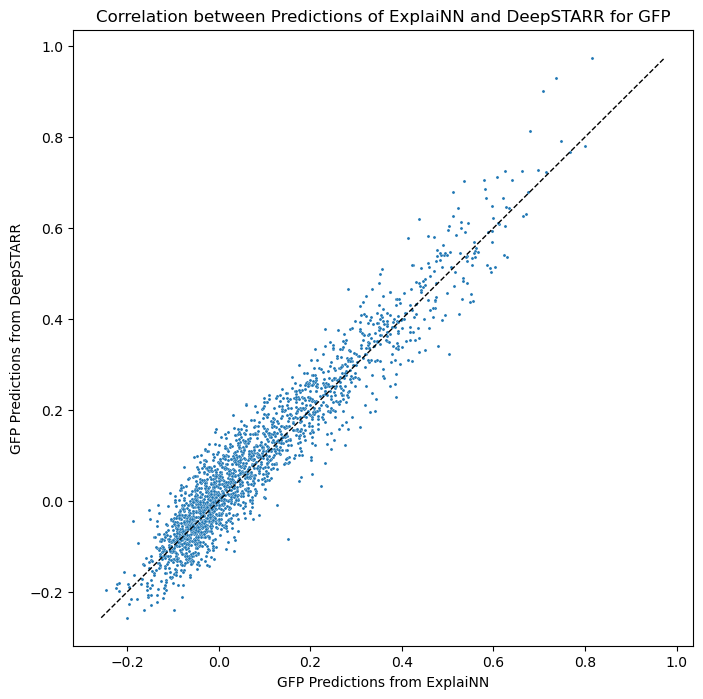

Pearson correlation for Predictions_GFP-: 0.9540482543787441


In [24]:
# Plot for Predictions_GFP
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP'], y=df_predictions['Predictions_GFP'], s=5)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP'].min(), df_predictions['Predictions_GFP'].min())
max_val = max(df_predictions_d['Predictions_GFP'].max(), df_predictions['Predictions_GFP'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('GFP Predictions from ExplaiNN')
plt.ylabel('GFP Predictions from DeepSTARR')
plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for GFP')

# Show the plot
plt.show()

from scipy.stats import pearsonr

# Calculate Pearson correlation for Predictions_GFP
correlation_gfp_minus, _ = pearsonr(df_predictions_d['Predictions_GFP'], df_predictions['Predictions_GFP'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")



# Train ExplaiNN Predict GFP with Rep1 data

In [3]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_GFP_Rep1_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 35]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 35
target_labels = ["GFP"]
feature_list = ["GFP"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep1_Pred_35NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_rep1_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 35
lr: 0.0001    drop_out: 0.3
batch: 96    seed: 920
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/104, Loss: 0.2972
Epoch 1/200 -- Train Loss: 0.2011 , Validation Loss: 0.1067
------------------------Evaluation------------------------
Label 1: MSE=0.1081, RMSE=0.3288, MAE=0.2597, R^2=-0.3116, Pearson=0.3384, Spearman=0.3244
Overall (Flattened): MSE=0.1081, RMSE=0.3288, MAE=0.2597, R^2=-0.3116, Pearson=0.3384, Spearman=0.3244
----------------------------------------------------------
Epoch 2/200, Step 1/104, Loss: 0.1613
Epoch 2/200 -- Train Loss: 0.1257 , Validation Loss: 0.0827
------------------------Evaluation------------------------
Label 1: MSE=0.0839, RMSE=0.2897, MAE=0.2248, R^2=-0.0183, Pearson=0.3724, Spearman=0.3475
Overall (Flattened): MSE=0.0839, RMSE=0.2897, MAE=0.2248, R^2=-0.0183, Pearson=0.3724, Spearman=0.3475
----------------------------------------------------------
Epoch 3/200, Step 1/104, Loss: 0.1024
Epoch 3/200 -- Train Loss: 0.1014 , V

In [4]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep1_Pred_35NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep1_Pred_35NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep1_Pred_35NN/best_pearson_model_epoch_29.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep1_Pred_35NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep1_Pred_35NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep1_Pred_35NN/test_prediction_results.csv


# Train ExplaiNN Predict GFP with Rep2 data

In [5]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_GFP_Rep2_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 20]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 20
target_labels = ["GFP"]
feature_list = ["GFP"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep2_Pred_20NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_rep2_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 20
lr: 0.0001    drop_out: 0.3
batch: 96    seed: 886
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/103, Loss: 0.2765
Epoch 1/200 -- Train Loss: 0.1742 , Validation Loss: 0.0999
------------------------Evaluation------------------------
Label 1: MSE=0.1002, RMSE=0.3166, MAE=0.2459, R^2=0.0876, Pearson=0.3993, Spearman=0.3703
Overall (Flattened): MSE=0.1002, RMSE=0.3166, MAE=0.2459, R^2=0.0876, Pearson=0.3993, Spearman=0.3703
----------------------------------------------------------
Epoch 2/200, Step 1/103, Loss: 0.1924
Epoch 2/200 -- Train Loss: 0.1372 , Validation Loss: 0.0949
------------------------Evaluation------------------------
Label 1: MSE=0.0957, RMSE=0.3093, MAE=0.2401, R^2=0.1291, Pearson=0.4232, Spearman=0.3827
Overall (Flattened): MSE=0.0957, RMSE=0.3093, MAE=0.2401, R^2=0.1291, Pearson=0.4232, Spearman=0.3827
----------------------------------------------------------
Epoch 3/200, Step 1/103, Loss: 0.1101
Epoch 3/200 -- Train Loss: 0.1216 , Valid

In [6]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep2_Pred_20NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep2_Pred_20NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep2_Pred_20NN/best_pearson_model_epoch_17.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep2_Pred_20NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep2_Pred_20NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Rep2_Pred_20NN/test_prediction_results.csv
